In [1]:
!pip install uv --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.1/22.1 MB 20.0 MB/s eta 0:00:00


In [2]:
!uv venv
!source .venv/bin/activate

Using CPython 3.12.12 interpreter at: /usr/bin/python3
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate


In [3]:
!uv pip install torchinfo --quiet

In [4]:
from huggingface_hub import snapshot_download
snapshot_download("hypersunflower/ava_speech_data_log_mel_spec", local_dir = "data/human-ava-speech", repo_type="dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

dataset.npz:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/707 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

'/content/data/human-ava-speech'

In [28]:
import os

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchinfo import summary

from trainerAndTester import trainAndTestModel

device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)

In [6]:
data = np.load(os.path.abspath("data/human-ava-speech/dataset.npz"))
mel = data["mel"]
onset = data["onset"]
offset = data["offset"]
filenames = data["filenames"]

# **Data preparation**

In [7]:
batch_size = 32
n_epochs = 10


files = np.unique(filenames)
np.random.shuffle(files)

train_size = 0.7
val_size = 0.1
test_size = 0.2

train_files_indices = int(round(train_size * files.shape[0], 0))
val_files_indices = int(round(val_size * files.shape[0], 0)) + train_files_indices
test_files_indices = int(round(test_size * files.shape[0], 0)) + val_files_indices


train_files = files[:train_files_indices]
val_files = files[train_files_indices:val_files_indices]
test_files = files[val_files_indices:]


train_indices = np.where(filenames == train_files)[0]
val_indices = np.where(filenames == train_files)[0]
test_indices = np.where(filenames == train_files)[0]

In [8]:
onset_offset = np.concat([onset, offset], axis=1)

In [9]:
def create_vad_dataloader(features, targets, batch_size, device):

    features = F.normalize(torch.from_numpy(features).to(device)).unsqueeze(1)
    target = torch.from_numpy(targets).to(device, dtype=torch.float32)

    dataset = TensorDataset(features, target)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [10]:
train_loader = create_vad_dataloader(
    features=mel[train_indices],
    targets=onset_offset[train_indices],
    device=device,
    batch_size=batch_size
)

val_loader = create_vad_dataloader(
    features=mel[val_indices],
    targets=onset_offset[val_indices],
    device=device,
    batch_size=batch_size
)

test_loader = create_vad_dataloader(
    features=mel[test_indices],
    targets=onset_offset[test_indices],
    device=device,
    batch_size=batch_size
)

# **model training**

## **defining the model**

In [11]:
class sadModel(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=64, num_layers=1, output_dim=800):
        super(sadModel, self).__init__()

        # GRU expects input: (seq_len, batch, input_size)
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_dim * 2 * 400, output_dim)  # 2 for bidirectional

    def forward(self, x):
        # x: (batch, 1, 40, 400) -> remove channel dim and permute
        x = x.squeeze(1).permute(0, 2, 1)  # (batch, 400, 40)

        # pass through gru
        out, _ = self.gru(x)  # out: (batch, 400, hidden_dim*2)

        # flatten time dimension
        out = out.contiguous().view(out.size(0), -1)  # (batch, 400*hidden_dim*2)

        out = self.fc(out)  # (batch, 800)

        return out

In [12]:
lr = 1e-3
weight_decay = 1e-6

vad = sadModel().to(device)

optimizer = torch.optim.Adam(vad.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()

In [13]:
summary(vad, (1, 40, 400))

Layer (type:depth-idx)                   Output Shape              Param #
sadModel                                 [1, 800]                  --
├─GRU: 1-1                               [1, 400, 128]             40,704
├─Linear: 1-2                            [1, 800]                  40,960,800
Total params: 41,001,504
Trainable params: 41,001,504
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 57.24
Input size (MB): 0.06
Forward/backward pass size (MB): 0.42
Params size (MB): 164.01
Estimated Total Size (MB): 164.49

## **metrics definition**

In [14]:
def accuracy(y_true, y_pred, eps=1e-12):
    per_sample = (y_true == y_pred).float().mean(dim=1)
    return per_sample.mean().item()

def hamming(y_true, y_pred, eps=1e-12):
    per_sample = (y_true != y_pred).float().mean(dim=1)
    return per_sample.mean().item()

def precision(y_true, y_pred, eps=1e-12):

    tp = ((y_pred == 1) & (y_true == 1)).sum().item()
    fp = ((y_pred == 1) & (y_true == 0)).sum().item()

    metric = tp / (tp + fp + eps)

    return metric

def recall(y_true, y_pred, eps=1e-12):

    tp = ((y_pred == 1) & (y_true == 1)).sum().item()
    fn = ((y_pred == 0) & (y_true == 1)).sum().item()

    metric = tp / (tp + fn + eps)

    return metric

def f1(y_true, y_pred, eps=1e-12):

    tp = ((y_pred == 1) & (y_true == 1)).sum().item()
    fp = ((y_pred == 1) & (y_true == 0)).sum().item()
    fn = ((y_pred == 0) & (y_true == 1)).sum().item()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)

    metric = (2 * precision * recall) / (precision + recall + eps)

    return metric

In [15]:
metrics = {
    "accuracy": accuracy,
    "hamming": hamming,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

## **model training**

In [32]:
trainer = trainAndTestModel(
    model=vad,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=20,
    metrics=metrics,
    output_is_raw_logits=True,
    final_activation_function_for_raw_logits=nn.Sigmoid()
)

In [33]:
model, history = trainer.train()

100%|██████████| 20/20 [05:02<00:00, 15.15s/it]


In [34]:
trainer.test()

Accuracy: 0.9997335702621911
Hamming: 0.00026641780162344825
Precision: 0.8787925906960056
Recall: 0.9112428392070824
F1: 0.891482200028549
Loss: 0.0012270811640994177


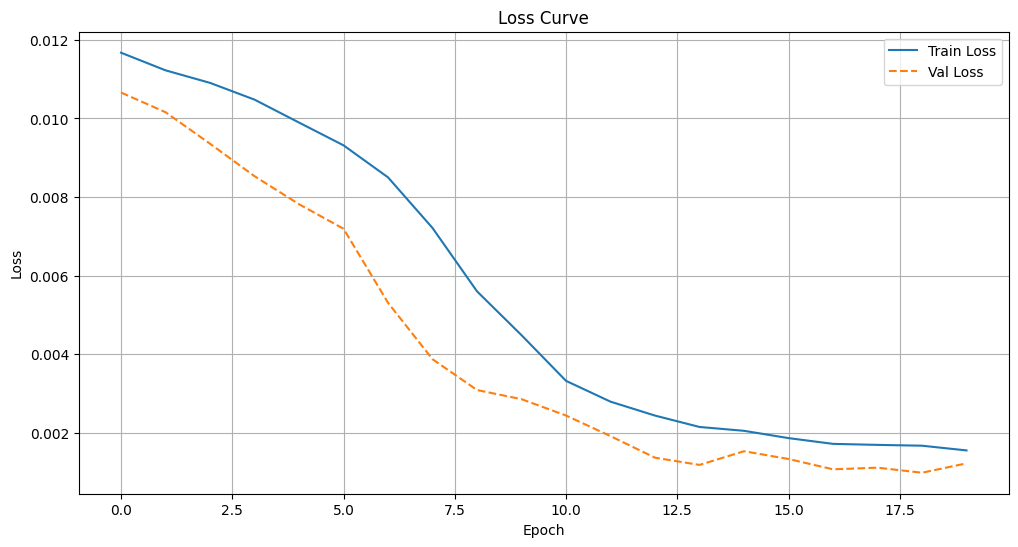

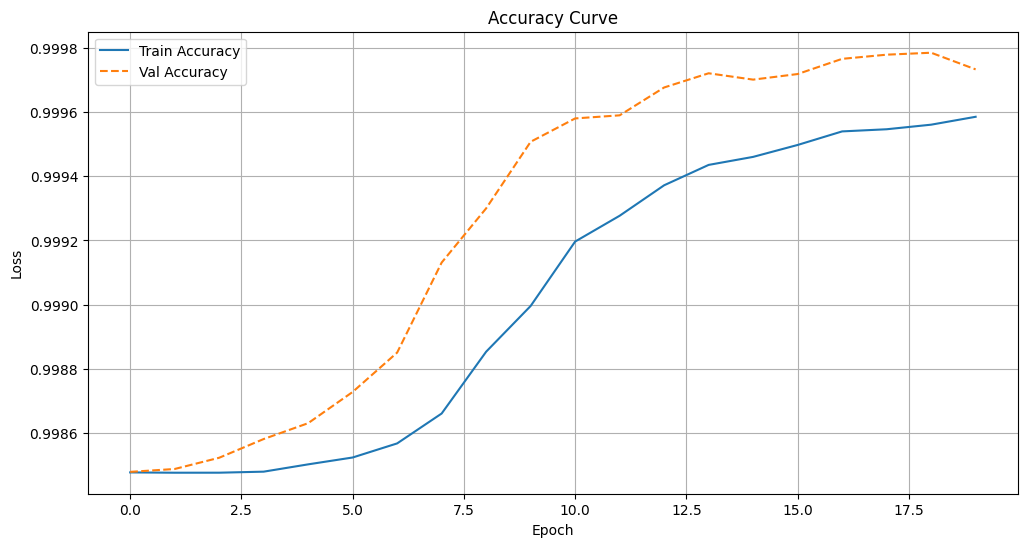

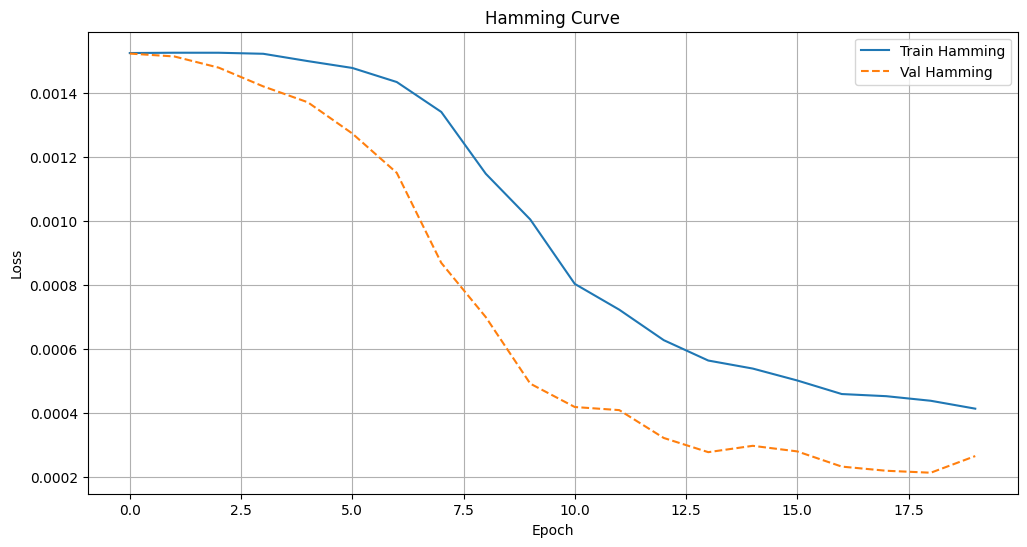

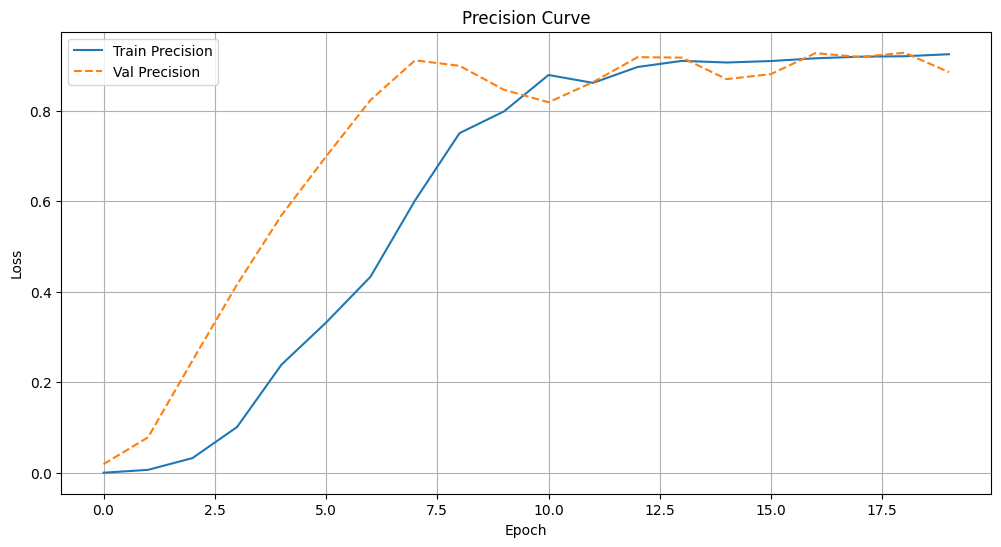

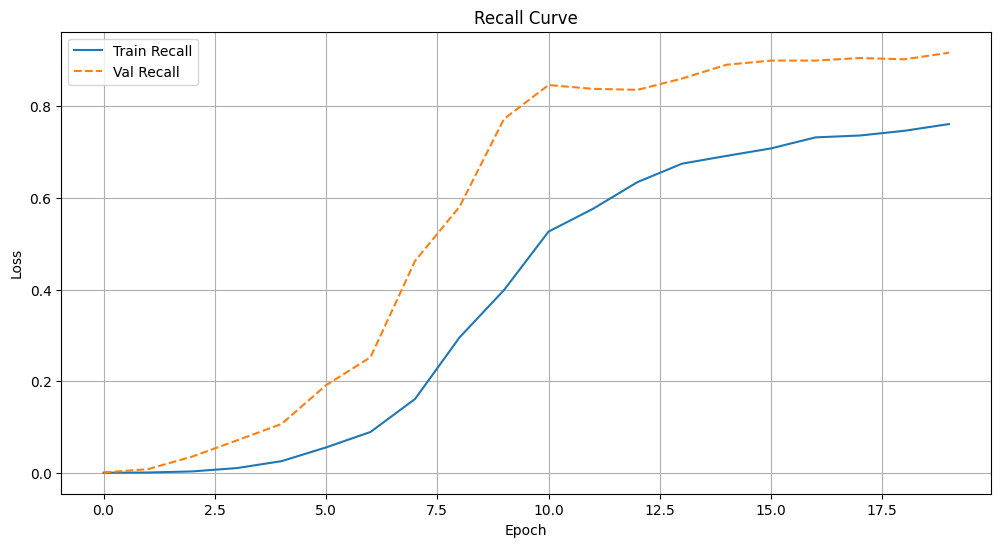

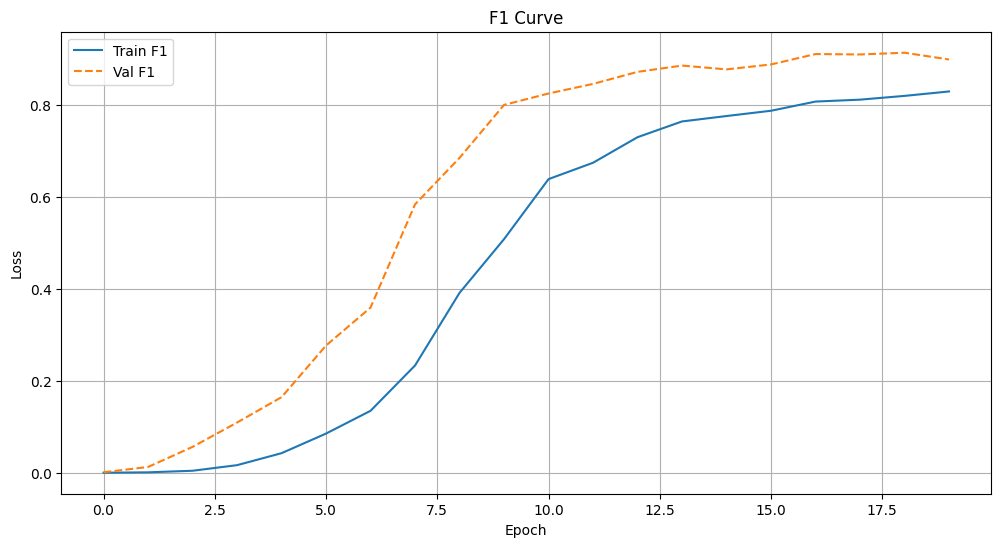

In [35]:
for key, value in history.items():

    plt.figure(figsize=(12, 6))
    plt.plot(value["train"], label=f"Train {key.capitalize()}")
    plt.plot(value["val"], label=f"Val {key.capitalize()}", linestyle='--')
    plt.title(f"{key.capitalize()} Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [36]:
path = "a_sad_model.pth"

In [37]:
torch.save(vad.state_dict(), path)